In [1]:
#Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.rcParams['figure.figsize'] = (12,8)

In [2]:
#Chargement des données
data = pd.read_csv('train.csv')

**Problématique : Prédire le prix d'un article**

# 1. EDA : Analyse exploratoire des données

In [3]:
print(f'Dimensions du dataset: {data.shape}')

Dimensions du dataset: (10000, 8)


In [4]:
data.sample(5)

train_id                           name  item_condition_id  \
7092    556165           Tc lularoe hedge hog                  2   
2002    590988                  Bundle charms                  1   
8555    918284  Forever 21 Polka Dot Cardigan                  3   
4036    591385       New XS VS PINK Boyshorts                  1   
2438   1173157            64 go micro Sd card                  1   

                                          category_name  brand_name  price  \
7092     Women/Athletic Apparel/Pants, Tights, Leggings         NaN   44.0   
2002              Vintage & Collectibles/Supplies/Charm         NaN   18.0   
8555                            Women/Sweaters/Cardigan  FOREVER 21   11.0   
4036                            Women/Underwear/Panties        PINK   11.0   
2438  Electronics/Cell Phones & Accessories/Cell Pho...         NaN   16.0   

      shipping                                   item_description  
7092         0                                 No description yet  
2002         1                                    Bundle 2 charms  
8555         0  Good quality, sturdy material, and super cute ...  
4036         1  New in packaging Size XS Victoria's Secret PIN...  
2438         1                                          Brand new

In [5]:
data.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

Ce premier aperçu des données nous permet d'identifier le type des différents attributs:
- train_id : variable numérique représentant l'id d'un article. Cet attribut ne sera pas utilisé pour prédire le prix d'un article, nous la laisserons de côté.
- name : variable textuelle, nom de l'article
- item_condition_id : variable catégorielle (ordinale) encodée (catégories déjà représentées par des index)
- category_name : variable catégorielle représentée par une chaine de caractère
- brand_name : variable textuelle
- price : variable numérique (variable cible)
- shipping : variable catégorielle (nominale) encodée
- item_description : variable textuelle

In [6]:
#Retire la colonne train_id
data.drop(columns='train_id', inplace=True)

## Data Cleaning

In [8]:
#Affiche le nombre de valeurs manquantes
data.isna().sum()

name                    0
item_condition_id       0
category_name          51
brand_name           4255
price                   0
shipping                0
item_description        0
dtype: int64

Seules les colonnes category_name et brand_name ont des valeurs manquantes. On les remplacera par 'N/A'.

In [9]:
#Remplace les valeurs manquantes par N/A (not available)

data['category_name'] = data['category_name'].fillna('N/A')
data['brand_name'] = data['brand_name'].fillna('N/A')

In [10]:
data.isna().sum()

name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [11]:
#Statistiques descriptives
data[['item_condition_id', 'price', 'shipping']].describe()

item_condition_id         price      shipping
count       10000.000000  10000.000000  10000.000000
mean            1.906600     27.284550      0.444400
std             0.902418     39.560632      0.496924
min             1.000000      0.000000      0.000000
25%             1.000000     11.000000      0.000000
50%             2.000000     17.000000      0.000000
75%             3.000000     29.000000      1.000000
max             5.000000   1259.000000      1.000000

In [12]:
#Statistiques descriptives des variables textuelles
data[['name', 'category_name', 'brand_name', 'item_description']].describe()

name                                   category_name brand_name  \
count    10000                                           10000      10000   
unique    9845                                             630        765   
top     Bundle  Women/Athletic Apparel/Pants, Tights, Leggings        N/A   
freq        14                                             415       4255   

          item_description  
count                10000  
unique                9322  
top     No description yet  
freq                   521

In [13]:
#Statistiques descriptives pour le prix
data.price.describe()

count    10000.000000
mean        27.284550
std         39.560632
min          0.000000
25%         11.000000
50%         17.000000
75%         29.000000
max       1259.000000
Name: price, dtype: float64

In [14]:
data['category_name'].sample(10)

7256                 Sports & Outdoors/Team Sports/Soccer
5692                              Women/Jewelry/Necklaces
6281          Sports & Outdoors/Outdoors/Hiking & Camping
3896                                Kids/Girls (4+)/Shoes
538                    Home/Home Décor/Home Décor Accents
5948       Home/Kitchen & Dining/Coffee & Tea Accessories
7971            Men/Sweats & Hoodies/Sweatshirt, Pullover
265     Electronics/Cell Phones & Accessories/Cases, C...
5292                       Women/Dresses/Above Knee, Mini
88                                        Kids/Toys/Games
Name: category_name, dtype: object

Il semblerait que l'attribut 'category_name' représente en fait 3 catégories séparées par un '/':
- une catégorie primaire
- une catégorie secondaire
- une catégorie tertiaire

Nous allons extraire ces 3 types de catégories.

In [15]:
#Fonction qui permet de split la chaine de caractère afin de mettre les 3 catégories dans une liste.
def process_category(category_string):
    return ["N/A","N/A","N/A"] if category_string == 'N/A' else category_string.split('/')

In [16]:
#Creation des 3 variables pour représenter les 3 types de catégories.

data['category_name'] = data['category_name'].apply(process_category)

data['primary_category'] = data['category_name'].apply(lambda x : x[0])
data['secondary_category'] = data['category_name'].apply(lambda x : x[1])
data['tertiary_category'] = data['category_name'].apply(lambda x : x[2])

data.drop(columns='category_name', axis=1, inplace=True)

In [17]:
#Affiche en autres le nombre de catégories par type de catégorie
data[['primary_category', 'secondary_category', 'tertiary_category']].describe()

primary_category secondary_category        tertiary_category
count             10000              10000                    10000
unique               11                103                      470
top               Women   Athletic Apparel  Pants, Tights, Leggings
freq               4474                907                      415

In [18]:
data.sample(5)

name  item_condition_id  \
4665   Rare Iridescent Adidas Superstars✨ HOLD                  1   
5532  7 For All Mankind "A" Pocket Jeans 29x33                  3   
5908  Free ship stunning blush scoop maxi dres                  3   
5187                        Nike pro hypercool                  3   
7215                                Tory Burch                  4   

              brand_name  price  shipping  \
4665              Adidas   86.0         0   
5532  7 For All Mankind®   25.0         0   
5908                 N/A   10.0         1   
5187                Nike   25.0         1   
7215          Tory Burch   30.0         0   

                                       item_description primary_category  \
4665  Women size 5.5, 6, 6.6, 7 & 7.5 AVAILABLE (ONL...            Women   
5532  7 For All Mankind "A" Pocket Darkwash Jeans wi...            Women   
5908               Pre owned but in beautiful condition            Women   
5187                    Capri. Nice and clean. Reg.[rm]            Women   
7215                   Pretty worn out. Still look okay            Women   

     secondary_category        tertiary_category  
4665              Shoes         Fashion Sneakers  
5532              Jeans                 Boot Cut  
5908            Dresses              Full-Length  
5187   Athletic Apparel  Pants, Tights, Leggings  
7215              Shoes                    Flats

## Data Visualisation

Nous allons ici réaliser quelques visualisations pour acquérir des connaissances sur les données.

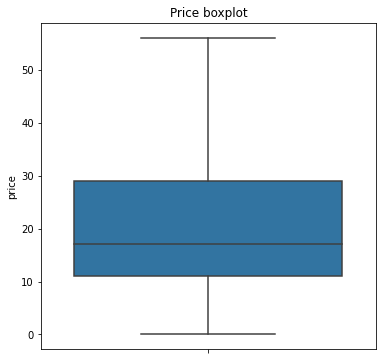

In [19]:
#Box plot pour le prix
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.boxplot(data=data, y='price', showfliers=False)
ax.set(title='Price boxplot')
plt.show()

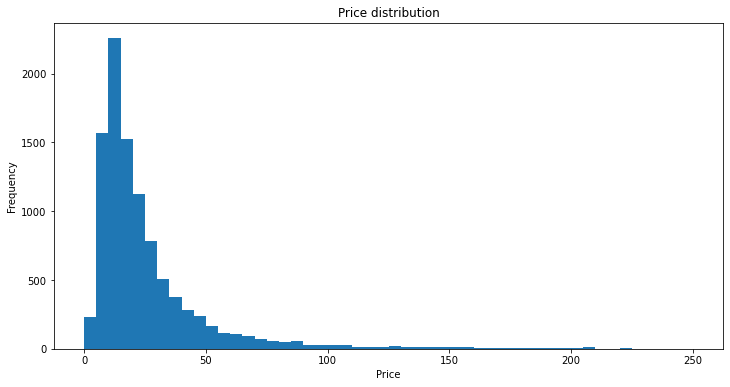

In [20]:
#Distribution du prix
fig, ax = plt.subplots(figsize=(12,6))
ax = data['price'].plot.hist(bins=50, range=[0,250])
ax.set(title='Price distribution', xlabel='Price', ylabel='Frequency')
plt.show()

primary_category
Electronics               38.101149
Men                       34.597243
Sports & Outdoors         31.160221
Women                     28.962338
N/A                       28.784314
Vintage & Collectibles    25.181230
Home                      24.115942
Kids                      21.372751
Beauty                    20.234559
Other                     20.080386
Handmade                  18.804762
Name: price, dtype: float64


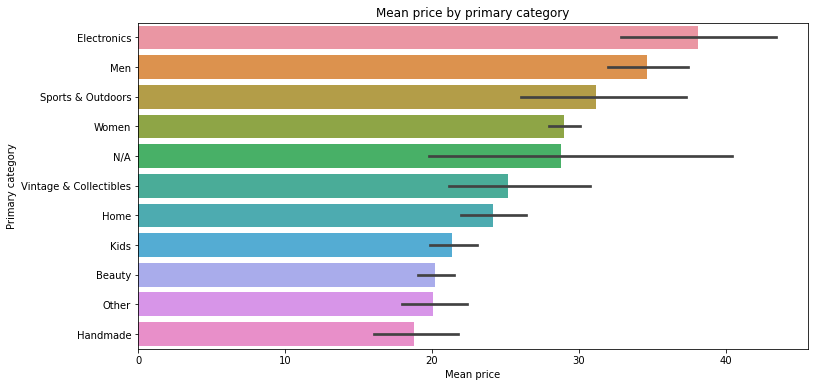

In [21]:
#Prix moyen par catégorie primaire

mean_price_by_cat = data.groupby('primary_category').price.mean().sort_values(ascending=False)
print(mean_price_by_cat)

fig, ax = plt.subplots(figsize=(12,6))
ax = sns.barplot(y='primary_category', x='price', data=data, order=mean_price_by_cat.index)
ax.set(xlabel='Mean price', ylabel='Primary category', title='Mean price by primary category')
plt.show()

Le prix moyen varie significativement en fonction de la catégories primaires. Cette variable devrait donc à priori être utile pour notre modèle.

primary_category
Women                     129577.5
Electronics                33148.0
Beauty                     27519.0
Kids                       24942.0
Men                        22592.0
Home                        9984.0
Vintage & Collectibles      7781.0
Other                       6245.0
Sports & Outdoors           5640.0
Handmade                    3949.0
N/A                         1468.0
Name: price, dtype: float64


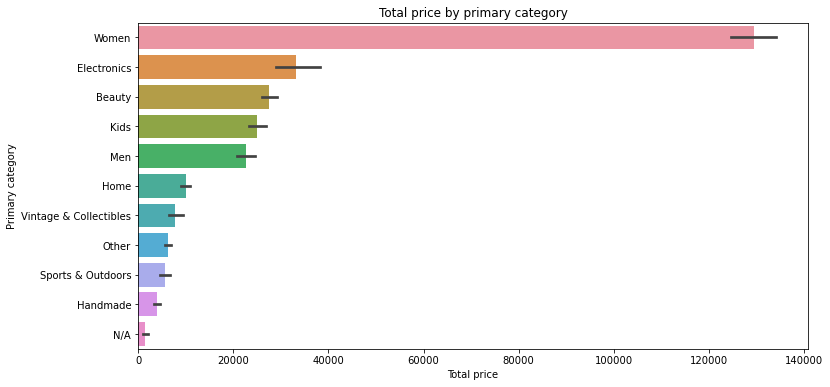

In [22]:
#Prix total par catégorie primaire

total_price_by_cat = data.groupby('primary_category').price.sum().sort_values(ascending=False)
print(total_price_by_cat )

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(y='primary_category', x='price', data=data, estimator=sum, order=total_price_by_cat.index)
ax.set(xlabel='Total price', ylabel='Primary category', title='Total price by primary category')
plt.show()

In [23]:
#Top catégories secondaires
data['secondary_category'].value_counts()

Athletic Apparel         907
Makeup                   821
Tops & Blouses           702
Shoes                    665
Jewelry                  424
                        ... 
Furniture                  1
Geekery                    1
Blazers & Sport Coats      1
Candles                    1
Holidays                   1
Name: secondary_category, Length: 103, dtype: int64

In [24]:
#Top catégories tertiaires
data['tertiary_category'].value_counts()

Pants, Tights, Leggings       415
Face                          325
Other                         319
T-Shirts                      317
Shoes                         217
                             ... 
Snowboard                       1
Sets & Kits                     1
Golf Apparel                    1
Lacrosse                        1
Grooming & Healthcare Kits      1
Name: tertiary_category, Length: 470, dtype: int64

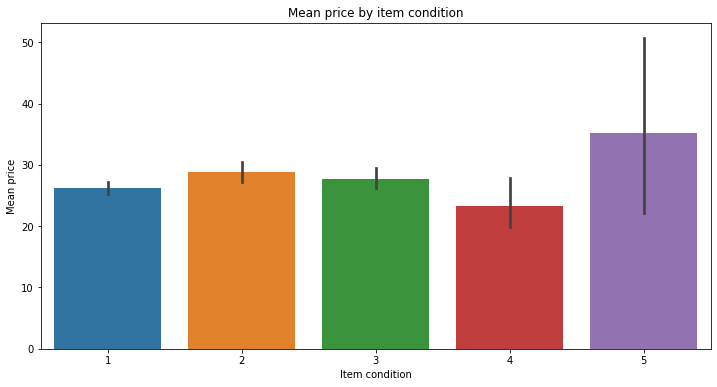

In [25]:
#Prix moyen par item_condition_id
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.barplot(x='item_condition_id', y='price', data=data)
ax.set(xlabel='Item condition', ylabel='Mean price', title='Mean price by item condition')
plt.show()

1    4302
3    2862
2    2592
4     226
5      18
Name: item_condition_id, dtype: int64


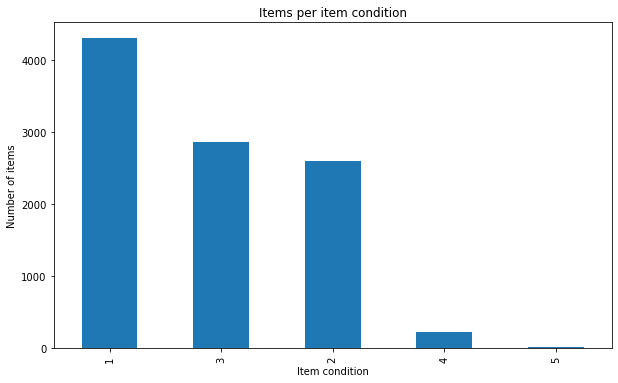

In [26]:
#Nombre d'articles par condition
per_condition_dist = data['item_condition_id'].value_counts()
print(per_condition_dist)

fig, ax = plt.subplots(figsize=(10,6))
ax = per_condition_dist.plot.bar()
ax.set(xlabel='Item condition', ylabel='Number of items', title='Items per item condition')
plt.show()

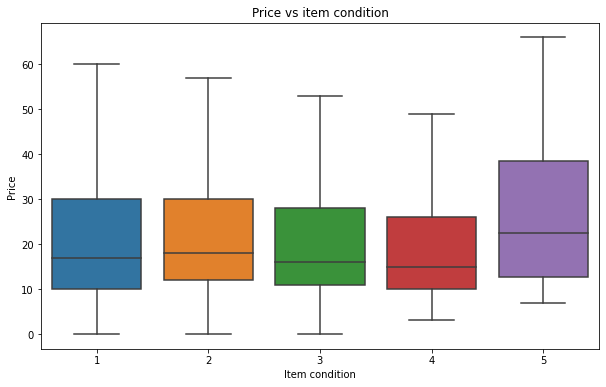

In [27]:
#Boxplot du prix par condition
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x='item_condition_id', y='price', data=data, showfliers=False)
ax.set(xlabel='Item condition', ylabel='Price', title='Price vs item condition')
plt.show()

Nike                 374
PINK                 349
Victoria's Secret    309
LuLaRoe              194
Apple                119
Michael Kors         115
FOREVER 21           109
Lululemon             99
Nintendo              96
Rae Dunn              86
Name: brand_name, dtype: int64


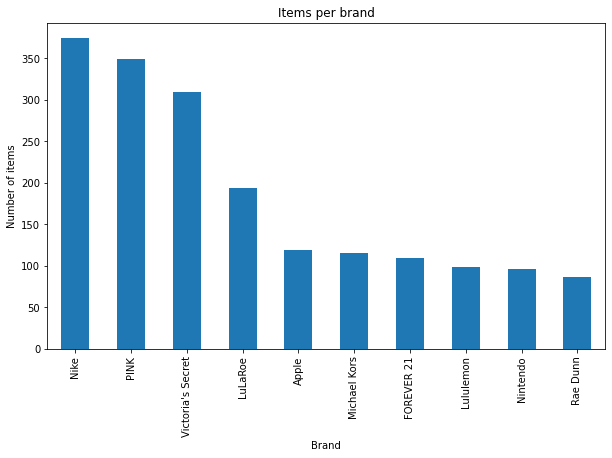

In [28]:
#Nombre d'item par marque
items_per_brand = data['brand_name'].value_counts().sort_values(ascending=False)
top_10_brands = items_per_brand.drop(labels='N/A', axis=0).iloc[:10]
print(top_10_brands)

fig, ax = plt.subplots(figsize=(10,6))
ax = top_10_brands.plot.bar()
ax.set(xlabel='Brand', ylabel='Number of items', title='Items per brand')
plt.show()

brand_name
David Yurman         257.500000
Sherri Hill          241.666667
Versace              213.000000
Louis Vuitton        211.714286
Terani Couture       199.000000
Mackintosh           190.000000
PoGo! Products       181.000000
Rawlings             173.000000
A Bathing Ape        166.000000
Wilson               159.000000
Acer                 129.000000
Frye                 116.000000
Beats                114.071429
Badgley Mischka      111.000000
Yeezy                106.000000
Silpada              104.000000
Agent Provocateur    104.000000
Apple                103.932773
Gucci                103.800000
Beach Bunny          103.000000
Name: price, dtype: float64


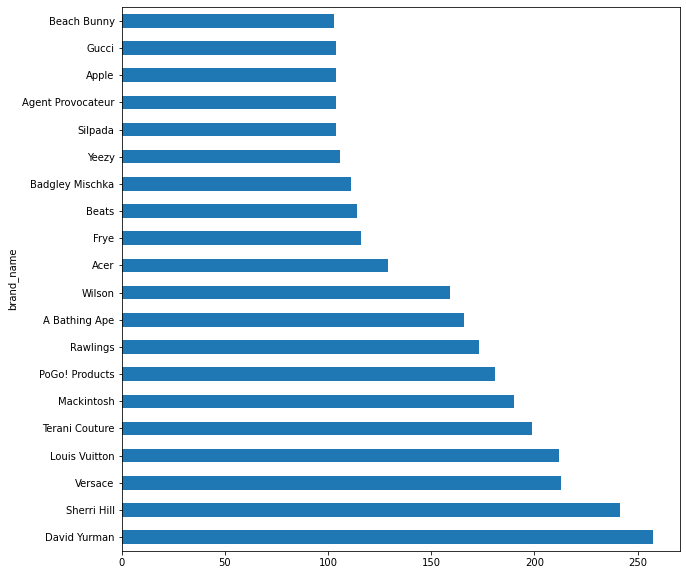

In [29]:
#Prix moyen par marque
mean_price_by_brand = data.groupby('brand_name').price.mean().sort_values(ascending=False)[:20]
print(mean_price_by_brand)

fig, ax = plt.subplots(figsize=(10, 10))
ax = mean_price_by_brand.plot.barh()

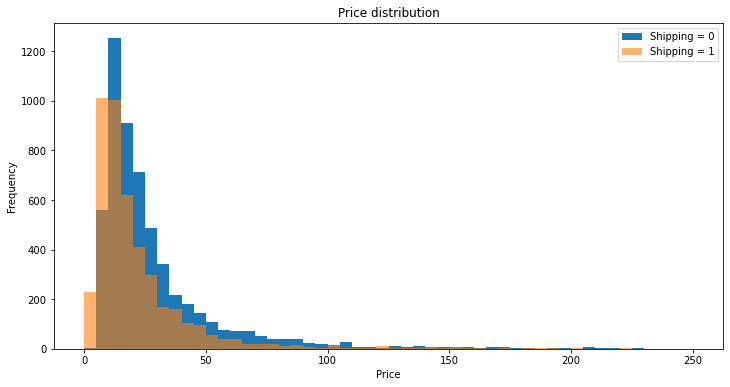

In [30]:
#Distribution du prix pour shipping 0 et 1

price_shipping0 = data[data['shipping'] == 0]['price']
price_shipping1 = data[data['shipping'] == 1]['price']

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(price_shipping0, bins=50, range=[0,250], label='Shipping = 0')
ax.hist(price_shipping1, bins=50, range=[0,250], alpha=0.6, label='Shipping = 1')
ax.set(title='Price distribution', xlabel='Price', ylabel='Frequency')
plt.legend()
plt.show()

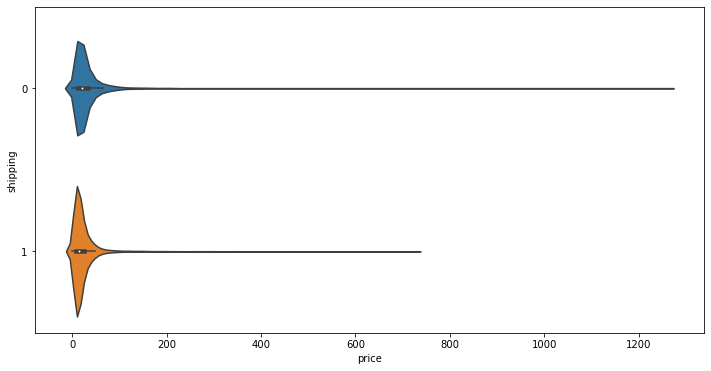

In [31]:
#Violin plot du prix pour shipping 0 et 1
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.violinplot(y='shipping', x='price', data=data, orient='h')
plt.show()

# 2. Feature Engineering

L'objectif est désormais de transformer les features pour obtenir un dataset adapté aux modèles de machine-learning. <br>Pour le moment les données ont la forme suivante:

In [32]:
data.sample(3)

name  item_condition_id brand_name  price  \
6248        Samsung gear s2 smart watch                  2    Samsung  139.0   
4074                           CC Leboy                  1        N/A  106.0   
9373  Funko Pop Tyrant Target Exclusive                  1      Funko   35.0   

      shipping                                   item_description  \
6248         0  Samsung gear s2 smart watch in excellent condi...   
4074         0  The bag includes dust bag , shoulder strap. Wh...   
9373         0  Hello everyone I have a mint tyrant exclusive ...   

     primary_category         secondary_category          tertiary_category  
6248      Electronics  Cell Phones & Accessories  Cell Phones & Smartphones  
4074            Women           Women's Handbags      Messenger & Crossbody  
9373             Kids                       Toys   Action Figures & Statues

In [46]:
#On garde une partie des données pour tester et évaluer de manière non biaisée notre modèle final, 
#sur des données encore pas vues par notre modèle
train, test = train_test_split(data, test_size=0.2)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

#Separation des attributs et de la cible (prix)
X_train = train.drop('price', axis=1)
y_train = train['price']

X_test = test.drop('price', axis=1)
y_test = test['price']

print(X_train.shape)
print(X_test.shape)

(8000, 8)
(2000, 8)


## One Hot Encoding pour les variables categorielles

In [47]:
#Encodage (OneHot) des variables catégorielles
oh_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
cols_to_encode = ['item_condition_id', 'brand_name', 'primary_category', 'secondary_category', 'tertiary_category']

oh_enc.fit(X_train[cols_to_encode])

cat_encoded_train = pd.DataFrame(oh_enc.transform(X_train[cols_to_encode]))
cat_encoded_test = pd.DataFrame(oh_enc.transform(X_test[cols_to_encode]))

X_train = pd.merge(X_train.drop(cols_to_encode, axis=1), cat_encoded_train, left_index=True, right_index=True)
X_test = pd.merge(X_test.drop(cols_to_encode, axis=1), cat_encoded_test, left_index=True, right_index=True)

print(f'Dimensions du training set : {X_train.shape}')
print(f'Dimensions du test set : {X_test.shape}')

Dimensions du training set : (8000, 1250)
Dimensions du test set : (2000, 1250)


L'inconvénient d'utiliser un One Hot encoder sur des variables catégorielles avec beaucoup de catégories différentes comme c'est le cas ici est que cela augmente grandement le nombre de colonnes de nos données.

## Feature engineering de la variable name

Pour la variable name on utilisera un CountVectorizer.

In [48]:
#Paramètres du count vectorizer
min_df = 10
max_features = 500

count_vec = CountVectorizer(lowercase=True,
                     stop_words='english',
                    min_df=min_df,
                    max_features=max_features)

count_vec.fit(X_train['name'])

count_vec_features_train = pd.DataFrame(count_vec.transform(X_train['name']).toarray())
count_vec_features_test = pd.DataFrame(count_vec.transform(X_test['name']).toarray())

X_train = pd.merge(X_train.drop('name', axis=1),
                   count_vec_features_train, left_index=True, right_index=True)
X_test = pd.merge(X_test.drop('name', axis=1),
                   count_vec_features_test, left_index=True, right_index=True)

print(f'Dimensions du training set : {X_train.shape}')
print(f'Dimensions du test set : {X_test.shape}')

Dimensions du training set : (8000, 1749)
Dimensions du test set : (2000, 1749)


## Feature engineering de la variable item description

Pour la variable item_desciption on utilisera TF-IDF.

In [49]:
#Setting tfidf parameters
max_df = 0.8
min_df = 20
max_features = 500


tfidf_vec = TfidfVectorizer(lowercase=True, 
                            stop_words='english',
                            min_df=min_df,
                           max_df=max_df,
                           max_features=max_features)

tfidf_vec.fit(X_train['item_description'])

tfidf_features_train = pd.DataFrame(tfidf_vec.transform(X_train['item_description']).toarray())
tfidf_features_test = pd.DataFrame(tfidf_vec.transform(X_test['item_description']).toarray())

X_train = pd.merge(X_train.drop('item_description', axis=1), 
                   tfidf_features_train, left_index=True, right_index=True)
X_test = pd.merge(X_test.drop('item_description', axis=1), 
                   tfidf_features_test, left_index=True, right_index=True)

print(f'Dimensions du training set : {X_train.shape}')
print(f'Dimensions du test set : {X_test.shape}')

Dimensions du training set : (8000, 2248)
Dimensions du test set : (2000, 2248)


Finalement, les données sont de la forme:

In [50]:
X_train.sample(3)

shipping  0_x  1_x  2_x  3_x  4_x  5_x  6_x  7_x  8_x  ...  490  491  \
2201         0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
7470         0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4084         1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

      492  493  494  495  496  497  498  499  
2201  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7470  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4084  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 2248 columns]

# 3. Modélisation

Le but de cette partie est de construire un modèle efficace pour prédire le prix d'un article.
<br>Nous utilisons la cross-validation pour évaluer les modèles avec les données de training, et nous gardons les données de test pour évaluer le modèle final de manière non biaisée avec des données qu'il n'a pas encore vues.
<br>Nous utiliserons la métrique MAE (mean absolute error) pour évaluer les modèles.

## Baseline model

Construisons un modèle de base simple (ici Random Forest avec les paramètres par défaut) qui nous servira de référence.
<br> On évalue le modèle par k-fold cross-validation (k=5) avec la MAE.

In [53]:
rfr = RandomForestRegressor()
scores = cross_val_score(rfr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

In [54]:
print('Random Forest')
print('Mean absolute error : {:.2f}'.format(-scores.mean()))

Random Forest
Mean absolute error : 14.84


## Gradient Boosting Regressor

De le même manière, on évalue le modèle par k-fold cross-validation avec la MAE.

In [62]:
gbr = GradientBoostingRegressor()
scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

In [63]:
print('Gradient Boosting Regressor')
print('Mean absolute error : {:.2f}'.format(-scores.mean()))

Gradient Boosting Regressor
Mean absolute error : 15.96


Ce modèle avec les paramètres par défaut a des performances similaires à la Random Forest, voire même légérement inférieures, mais tentons tout de même de l'améliorer en ajustant les paramètres.

### Grid search pour ajuster les paramètres

In [64]:
params = {'learning_rate':[1, 0.5, 0.25, 0.1, 0.01],
         'n_estimators':[10,100,200],
         'max_depth': [3,6,10]}

regressor = GridSearchCV(gbr, param_grid=params, cv=5)
regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [1, 0.5, 0.25, 0.1, 0.01],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [10, 100, 200]})

In [70]:
best_params = regressor.best_params_
print(f'Meilleurs paramètres:\n{best_params}')

Meilleurs paramètres:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


### Modèle final

In [73]:
#Modèle final avec les meilleurs paramètres trouvés avec la GridSearch
final_model = GradientBoostingRegressor(**best_params)

#Training avec toutes les données de train
final_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=200)

In [86]:
#Evaluation du modèle avec les données de train
y_train_pred = final_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)


#Evaluation du modèle avec des données encore non vues par le modèle
y_test_pred = final_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)

print('Résultats du modèle final avec les données de train')
print('Mean absolute error : {:.2f}'.format(mae_train))
print('-------------------')
print('Résultats du modèle final avec les données de test')
print('Mean absolute error : {:.2f}'.format(mae_test))

Résultats du modèle final avec les données de train
Mean absolute error : 13.06
-------------------
Résultats du modèle final avec les données de test
Mean absolute error : 16.22


In [108]:
#Dataframe avec les données de test et les prédictions
df_price_pred = pd.DataFrame(list(zip(y_test, y_test_pred)), columns=['actual_price', 'predicted_price'])
test_with_preds = pd.merge(test.drop('price',axis=1), df_price_pred, left_index=True, right_index=True)

In [109]:
test_with_preds.sample(5)

name  item_condition_id         brand_name  \
977        pink thrasher t shirt                  1  Thrasher Magazine   
1118  Nike LEbron X low size 9.5                  1               Nike   
1313       3 for [rm] headbands!                  1                N/A   
1326     Gameboy, games & Extras                  3           Nintendo   
344                    Nike Shox                  3               Nike   

      shipping                                   item_description  \
977          0  RARE ! pink thrasher t shirt size small (unise...   
1118         0  Brand new lebron 10 low Never worn OG box Grea...   
1313         0  Handmade crochet knotted headbands/ ear warmer...   
1326         0  Original Gameboy system. Works great! Comes wi...   
344          0                            Girls Nike Shox size 6Y   

     primary_category      secondary_category tertiary_category  actual_price  \
977             Women          Tops & Blouses          T-Shirts          44.0   
1118              Men                   Shoes          Athletic          56.0   
1313            Women     Women's Accessories  Hair Accessories           8.0   
1326      Electronics  Video Games & Consoles          Consoles          41.0   
344              Kids              Girls (4+)             Shoes          10.0   

      predicted_price  
977         25.689648  
1118        54.928498  
1313        23.168682  
1326        64.282563  
344         22.386725

Les performances du modèle ne sont pas vraiment satisfaisantes. Il faudrait continuer de travailler à la fois sur les features et le modèle pour améliorer les performances:
- Identifier et analyser les données sur lesquelles le modèle a du mal à predire le prix pour améliorer les features et le modèle
- Expérimenter en ajustant les paramètres utilisés pour le feature engineering (CountVectorize, TF-IDF, etc.) pour améliorer la qualité des features et ainsi les performances du modèle
- Expérimenter d'autres paramètres et d'autres modèles

Une autre piste d'amélioration serait de réduire le nombre de features avec une technique de réduction de dimension telle que PCA par exemple.